In [1]:
# Instalando uma atualização do matplotlib (Nota: Como a atualização já foi feita não precisa repetir novamente, por isso eu comentei a linha da atualização do matplotlib)
!pip install -U matplotlib

In [2]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import pandas_profiling
from pandas_profiling import ProfileReport

In [3]:
# Carregando a base de dados
url = 'https://github.com/tathi-martins/Predict_ICU_for_COVID-19/raw/main/DATA/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
dados = pd.read_excel(url)

In [4]:
# Primeira olhada nos dados
dados

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

Podemos perceber que cada paciente tem em torno de 5 linhas, cada uma dessas correspondem a uma janela de tempo, ou seja, o período de tempo que estes pacientes ficaram internados no hospital. Temos uma coluna que identifica os pacientes como a "PATIENT_VISIT_IDENTIFIER", assim como as colunas que contém características pessoais dos pacientes como a idade, o gênero e algumas doenças prévias. O dataset também possui as colunas que contém os dados médicos dos pacientes como os sinais vitais e exames laboratoriais, além da coluna alvo, a ICU, que informa se o paciente foi para a UTI ou não.

In [5]:
# Obtendo mais informações sobre o dataset, como o número de colunas e os tipos de dados.
display(dados.info())
dados.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


None

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,BILLIRUBIN_MIN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,1925.000000,1925.000000,1925.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,1920.000000,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,821.000000,821.0,821.000000,821.000000,821.000000,...,821.000000,821.000000,821.0,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1240.000000,1240.000000,1240.000000,1177.000000,1231.000000,1239.000000,1925.000000
mean,192.000000,0.467532,0.368831,0.108333,0.028125,0.097917,0.019792,0.128125,0.046875,0.213021,0.158333,0.809896,0.528527,0.528527,0.528527,0.528527,-1.0,-0.963433,-0.963433,-0.963433,-0.963433,-1.0,-0.931121,-0.931121,-0.931121,-0.931121,-1.0,-0.310924,-0.310924,-0.310924,-0.310924,-1.0,-0.311845,-0.311845,-0.311845,-0.311845,-1.0,-0.945928,-0.945928,-0.945928,...,-0.954177,-0.954177,-1.0,-0.093631,-0.332600,-0.264701,-0.438754,0.066893,0.743077,-0.097790,-0.338468,-0.268632,-0.435121,0.063798,0.748588,-0.040855,-0.207812,-0.264999,-0.483129,0.326823,0.817565,-0.235001,-0.399582,-0.282029,-0.316753,0.014964,0.818593,-0.752454,-0.728053,-0.754100,-0.703683,-0.770338,-0.887196,-0.786997,-0.715950,-0.817800,-0.719147,-0.771327,-0.886982,0.267532
std,111.168431,0.499074,0.482613,0.310882,0.165373,0.297279,0.139320,0.334316,0.211426,0.409549,0.365148,0.392485,0.224100,0.224100,0.224100,0.224100,0.0,0.160870,0.160870,0.160870,0.160870,0.0,0.169509,0.169509,0.169509,0.169509,0.0,0.100256,0.100256,0.100256,0.100256,0.0,0.118812,0.118812,0.118812,0.118812,0.0,0.076610,0.076610,0.076610,...,0.123582,0.123582,0.0,0.252064,0.274102,0.246760,0.217113,0.242858,0.132635,0.257733,0.277952,0.252709,0.225554,0.249208,0.125994,0.281304,0.277802,0.272725,0.278239,0.216198,0.283453,0.271123,0.287580,0.296247,0.402675,0.276163,0.141316,0.364001,0.408677,0.366349,0.482097,0.319001,0.296147,0.324754,0.419103,0.270217,0.446600,0.317694,0.296772,0.442787
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000

O dataset possui 1925 linhas e 231 colunas. Dentre estes 225 são do tipo float64, 4 do tipo int64 e 2 são do tipo object.

In [6]:
print('O número total de valores nulos são: ', dados.isnull().values.sum())

O número total de valores nulos são:  223863


In [7]:
# Separando as colunas por tipos de dados
category_columns = dados.select_dtypes(include=['object']).columns
numeric_columns = dados.select_dtypes(include=['int64']).columns
float_columns = dados.select_dtypes(include=['float64']).columns
print(category_columns)
print('\n')
print(numeric_columns)
print('\n')
print(float_columns)

Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')


Index(['PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'GENDER', 'ICU'], dtype='object')


Index(['DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'ALBUMIN_MEDIAN',
       ...
       'HEART_RATE_DIFF', 'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF',
       'OXYGEN_SATURATION_DIFF', 'BLOODPRESSURE_DIASTOLIC_DIFF_REL',
       'BLOODPRESSURE_SISTOLIC_DIFF_REL', 'HEART_RATE_DIFF_REL',
       'RESPIRATORY_RATE_DIFF_REL', 'TEMPERATURE_DIFF_REL',
       'OXYGEN_SATURATION_DIFF_REL'],
      dtype='object', length=225)


Agora que temos uma ideia geral dos nossos dados, vamos iniciar a fase de questionamentos para que possamos entender melhor o nosso problema e começar a fazer algumas hipóteses que podem ajudar em sua solução e na criação de um modelo de Machine Learning.

# **Quantos pacientes foram para a UTI em cada janela temporal?**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


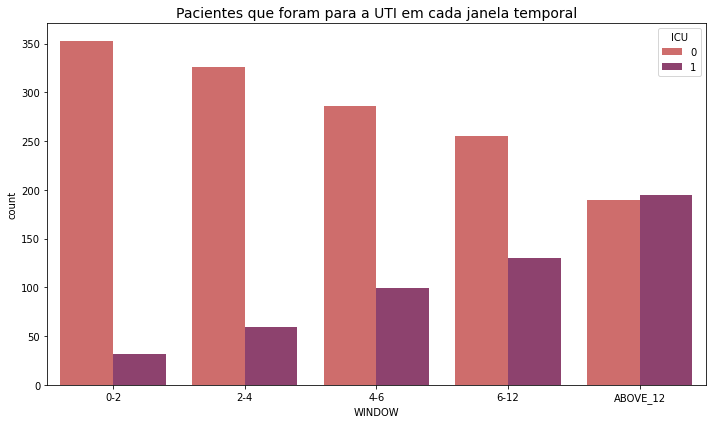

In [8]:
# Janela temporal dos pacientes 
plt.figure(figsize=(10,6))
plt.title('Pacientes que foram para a UTI em cada janela temporal', fontsize=14)
sns.countplot(dados['WINDOW'], hue='ICU', data=dados, palette='flare')
plt.tight_layout()

Podemos ver aqui que quanto mais o tempo avança, maior a chance de um paciente ir para a UTI, o que intensifica a importância de diagnosticar a severidade da doença o mais breve possível, de prever se um paciente irá para a UTI de forma mais precisa e precoce.

In [9]:
# Função que identifica quem foi para a uti e os traz para a janela 0-2
def seleciona_window(rows):
    if (np.any(rows['ICU'])): # Se o paciente foi para a UTI faça:
        rows.loc[rows['WINDOW'] == '0-2', 'ICU'] = 1 # Localiza as linhas do WINDOW 0-2 da coluna ICU e atribua o valor 1
    return rows.loc[rows['WINDOW'] == '0-2'] # retorna os resultados apenas da janela 0-2

# Agrupa os pacientes por ID e aplica a função que criamos acima
uti_s_n = dados.groupby('PATIENT_VISIT_IDENTIFIER').apply(seleciona_window).reset_index(drop=True)
uti_s_n.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.00,-0.162393,-0.5,0.208791,0.89899,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
1,1,1,90th,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.283951,-0.046154,0.188679,0.830508,-0.107143,1.000000,-0.283951,-0.046154,0.188679,0.862069,-0.107143,1.000000,-0.072165,0.15,0.264957,1.0,0.318681,1.00000,-0.504274,-0.329730,-0.059701,0.636364,-0.275362,1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,1
2,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,1
3,3,0,40th,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0
4,4,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0-2,0


# **Quantos pacientes foram para a UTI e quantos não foram por faixa etária?**

In [10]:
# Cria dois dataframes, um com os pacientes que foram para a UTI e outro com pacientes que não foram para a UTI
uti_n = uti_s_n.query('ICU == 0').copy()
uti_s = uti_s_n.query('ICU == 1').copy()

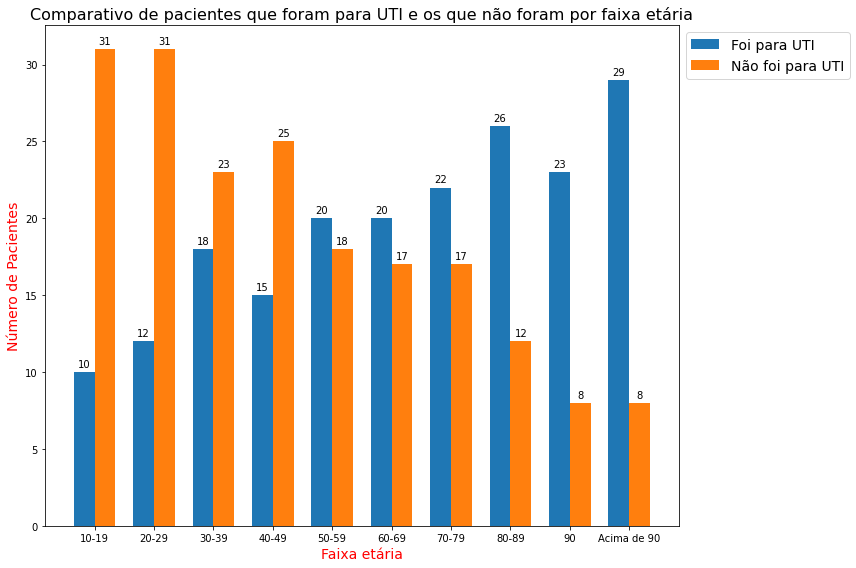

In [11]:
# Preparando dados
labels = ['10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90', 'Acima de 90']
sim_uti_idade = uti_s['AGE_PERCENTIL'].value_counts().sort_index().to_list() # Conta o número de pacientes por faixa etária, organiza na ordem do index '10 até Above 90' e coloca resultado em uma lista
nao_uti_idade = uti_n['AGE_PERCENTIL'].value_counts().sort_index().to_list() # Conta o número de pacientes por faixa etária

x = np.arange(len(labels))  # localização das labels
width = 0.35  # largura das barras

# Gráfico
fig, ax = plt.subplots(figsize=(12,8))
graph1 = ax.bar(x - width/2, sim_uti_idade, width, label='Foi para UTI')
graph2 = ax.bar(x + width/2, nao_uti_idade, width, label='Não foi para UTI')

# Configurando ticks, título, legenda
ax.set_ylabel('Número de Pacientes', fontsize=14, color='r')
ax.set_xlabel('Faixa etária', fontsize=14, color='r')
ax.set_title('Comparativo de pacientes que foram para UTI e os que não foram por faixa etária', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 2, bbox_to_anchor = (1, 1), fontsize=14)

# Adiciona texto em cima das barras
ax.bar_label(graph1, padding=3)
ax.bar_label(graph2, padding=3)

fig.tight_layout()

plt.show()

Com este gráfico podemos ver que quanto maior a idade, maior a chance de ir para a UTI. Confirmando o que a comunidade médica e científica diz, que a idade avançada é o fator de risco mais importante para desenvolver a forma grave da COVID-19.

In [12]:
fig.savefig("proj_final_grafico1.png")

# **Qual a média dos que foram para a UTI por sexo? Será que o sexo do paciente é um fator importante para desenvolver complicações?**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator


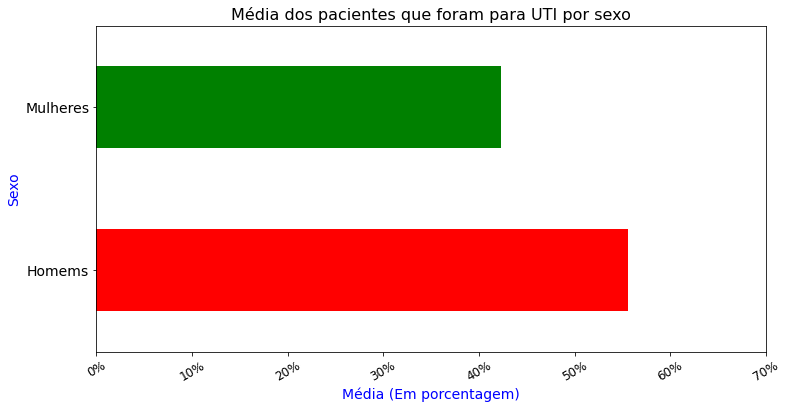

In [13]:
# Qual a média dos pacientes que foram para UTI por sexo.
media_uti_sexo = uti_s_n.groupby(by='GENDER')['ICU'].mean() * 100

# Gráfico
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
ax = media_uti_sexo.plot(kind='barh', color = my_colors, figsize=(12,6))

# Título do gráfico
plt.title('Média dos pacientes que foram para UTI por sexo', fontsize=16)

# Configurando as labels
labels = {'Homems': 0, 'Mulheres': 1}
plt.xlabel('Média (Em porcentagem)', fontsize=14, color='b')
plt.ylabel('Sexo', fontsize=14, color='b')
plt.xlim(0, 70)
ax.set_yticklabels(labels=labels, fontsize=14)
ax.set_xticklabels(labels, fontsize=12)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,g}%'))

# Configurando o eixo x
plt.xticks(rotation=30)

plt.show()

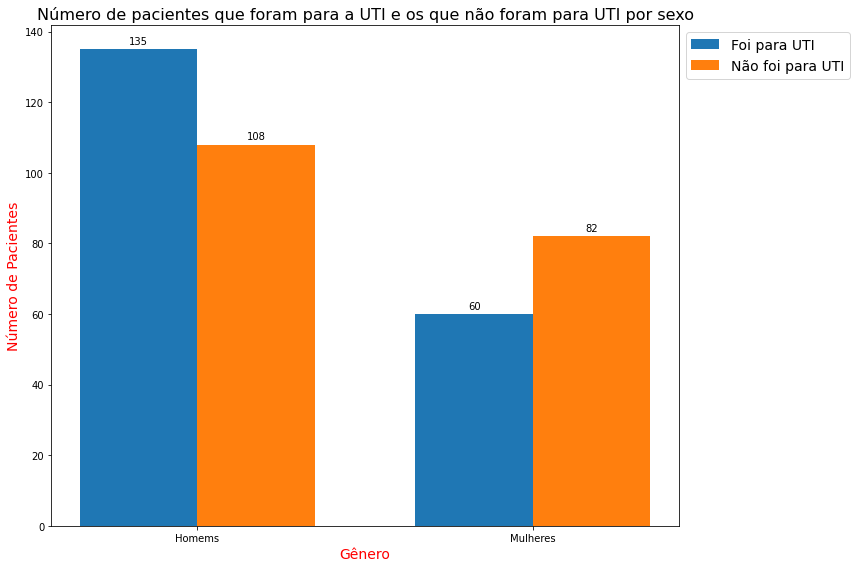

In [14]:
# Agora vamos ver qual foi a média de idade e a quantidade de pacientes que foram para a UTI e os que não foram para UTI por sexo.
# Preparando dados
labels = {'Homems': 0, 'Mulheres': 1}
sim_uti_sexo = uti_s['GENDER'].value_counts().to_list() # Conta o número de pacientes por faixa etária, organiza na ordem do index '10 até Above 90' e coloca resultado em uma lista
nao_uti_sexo = uti_n['GENDER'].value_counts().to_list() # Conta o número de pacientes por faixa etária

x = np.arange(len(labels))  # localização das labels
width = 0.35  # largura das barras

# Gráfico
fig, ax = plt.subplots(figsize=(12,8))
graph1 = ax.bar(x - width/2, sim_uti_sexo, width, label='Foi para UTI')
graph2 = ax.bar(x + width/2, nao_uti_sexo, width, label='Não foi para UTI')

# Configurando ticks, título, legenda
ax.set_ylabel('Número de Pacientes', fontsize=14, color='r')
ax.set_xlabel('Gênero', fontsize=14, color='r')
ax.set_title('Número de pacientes que foram para a UTI e os que não foram para UTI por sexo', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc = 2, bbox_to_anchor = (1, 1), fontsize=14)

# Adiciona texto em cima das barras
ax.bar_label(graph1, padding=3)
ax.bar_label(graph2, padding=3)

fig.tight_layout()

plt.show()

# **Qual foi a média de idade dos pacientes homens e mulheres que foram para a UTI?**

In [15]:
# Agora vamos ver qual foi a média de pacientes acima de 65 anos e quanto desses pacientes que foram para UTI e também os que não foram para UTI.

uti_s_n.groupby(['GENDER','ICU']).agg({'AGE_ABOVE65': np.mean, 'PATIENT_VISIT_IDENTIFIER': np.size})

AGE_ABOVE65  PATIENT_VISIT_IDENTIFIER
GENDER ICU                                       
0      0       0.314815                       108
       1       0.555556                       135
1      0       0.329268                        82
       1       0.733333                        60

**Contexto:**

- **Gender:**

-- 0 -> Refere-se aos homens;

-- 1 -> Refere-se as mulheres.

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.

In [16]:
# Transformando a coluna 'AGE_PERCENTIL' em valores categóricos numéricos, para gerar a média de idade para o gráfico abaixo
uti_s.loc[:,'AGE_PERCENTIL'] = uti_s.loc[:,'AGE_PERCENTIL'].astype('category').cat.codes

In [17]:
# Qual foi a média de idade dos pacientes homens e mulheres que foram para a UTI?
uti_media_idade_sexo = round(uti_s.groupby(['GENDER']).agg({'AGE_PERCENTIL': np.mean}) * 10) # Arredondando a média
uti_media_idade_sexo

,AGE_PERCENTIL
GENDER,
0,49.0
1,61.0


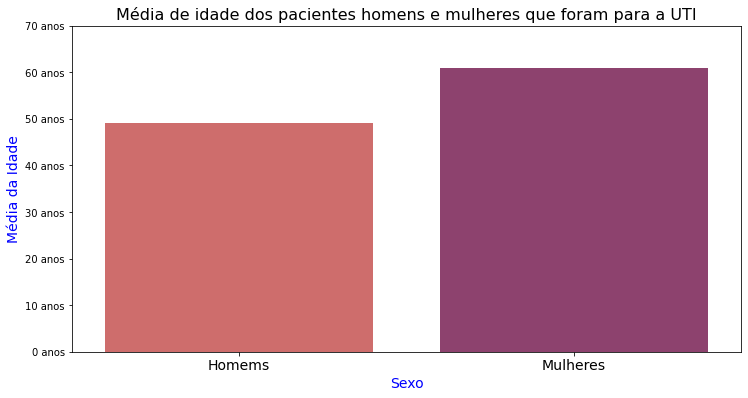

In [18]:
# Gráfico
plt.figure(figsize=(12,6))
ax = sns.barplot(x=uti_media_idade_sexo.index, y='AGE_PERCENTIL', data=uti_media_idade_sexo, palette='flare')

# Título do gráfico
plt.title('Média de idade dos pacientes homens e mulheres que foram para a UTI', fontsize=16)

# Configurando as labels
labels = {'Homems': 0, 'Mulheres': 1}
plt.xlabel('Sexo', fontsize=14, color='b')
plt.ylabel('Média da Idade', fontsize=14, color='b')
plt.ylim(0, 70)
ax.set_xticklabels(labels=labels, fontsize=14)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,g} anos'))

# Configurando o eixo x
plt.xticks(rotation=360)

plt.show()

Neste gráfico podemos ver que a média de idade de pacientes que foram para a UTI é bem diferente, com a diferença em torno de uma década entre os homens e mulheres. Não sabemos se isso é uma característica relevante ou que se repete em outros hospitais.

# **Qual é o impacto que as comorbidades tem na evolução do quadro clínico do paciente com COVID-19?**

Os especialistas dizem que algumas comorbidades como, hipertensão, diabetes, doenças do sistema cardiovascular, asma, obesidade, entre outras, trazem um impacto negativo sobre os infectados pelo coronavírus. Por isso vamos analisar o tamanho do impacto dessas enfermidades nos pacientes com COVID-19.

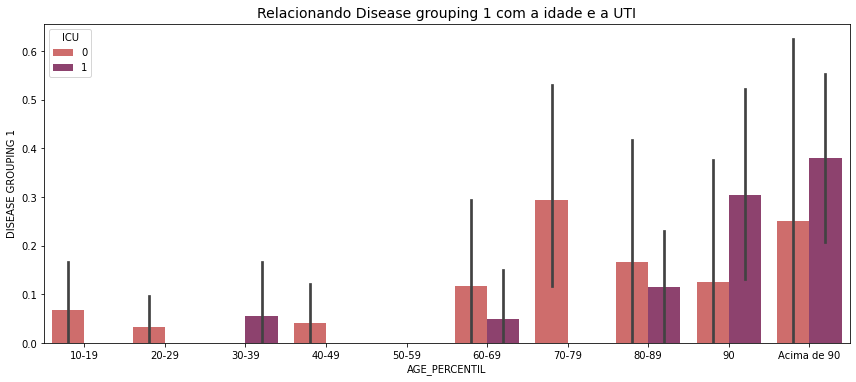

In [19]:
# Relacionando Disease Grouping 1 com idade e se há impacto na UTI
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Relacionando Disease grouping 1 com a idade e a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='DISEASE GROUPING 1', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)

plt.tight_layout()

**Contexto:**

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.

Ao observamos o gráfico, percebemos que o impacto da DISEASE GROUPING 1 aumenta com a idade do paciente, entre a faixa etária dos mais jovens essa influencia é quase nula, já que apenas na faixa etária dos 30 anos é que vemos pacientes com esta comorbidade que tenham ido para a UTI.

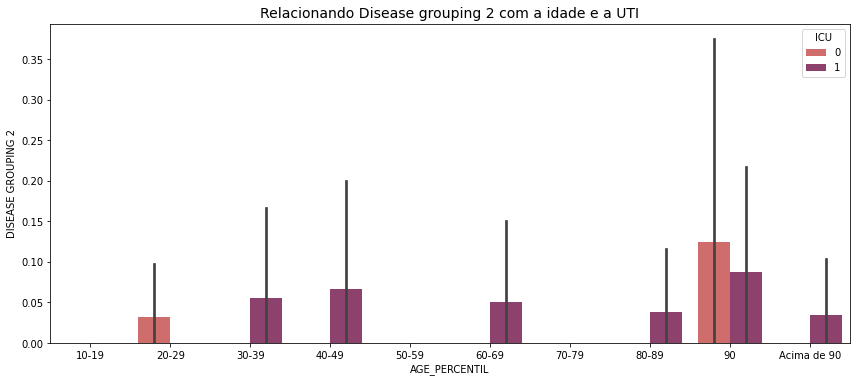

In [20]:
# Relacionando Disease Grouping 2 com idade
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Relacionando Disease grouping 2 com a idade e a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='DISEASE GROUPING 2', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.tight_layout()

**Contexto:**

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.


A DISEASE GROUPING 2 diferentemente do DISEASE GROUPING 1, parece ter contribuído com o agravamento de pacientes portadores desta comorbidade com idade mais jovem.

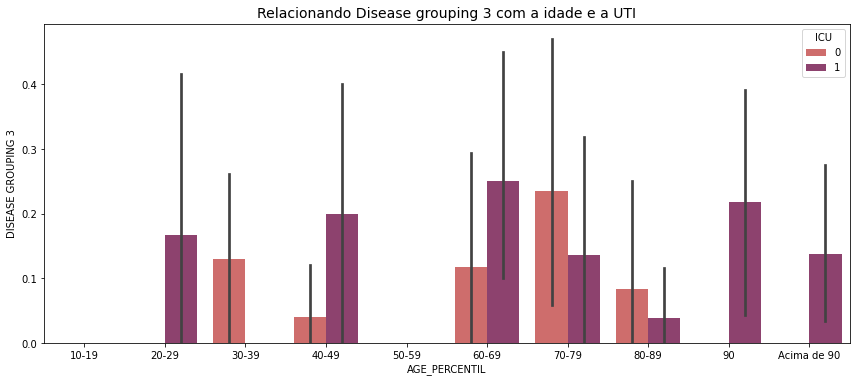

In [21]:
# Relacionando Disease Grouping 3 com idade
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Relacionando Disease grouping 3 com a idade e a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='DISEASE GROUPING 3', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.tight_layout()

**Contexto:**

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.

Portadores desta comorbidade parecem desenvolver complicações sérias de COVID-19, considerando que apenas nas faixas etárias de 70 e 80 anos o número de portadores que não foram para UTI superou o número de portadores que foram para UTI. Por ser uma amostra de dados pequena, não podemos afirmar se isto ocorre em todos os hospitais do Brasil.

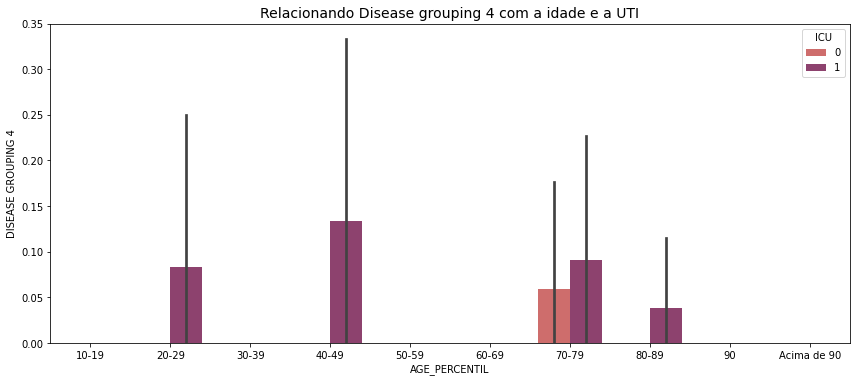

In [22]:
# Relacionando Disease Grouping 4 com idade
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Relacionando Disease grouping 4 com a idade e a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='DISEASE GROUPING 4', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.tight_layout()

**Contexto:**

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.

Outra comorbidade que afeta negativamente os pacientes com COVID-19, levando os portadores a desenvolver a forma mais grave da doença. Quase todos os pacientes portadores desta doença foram para a UTI.

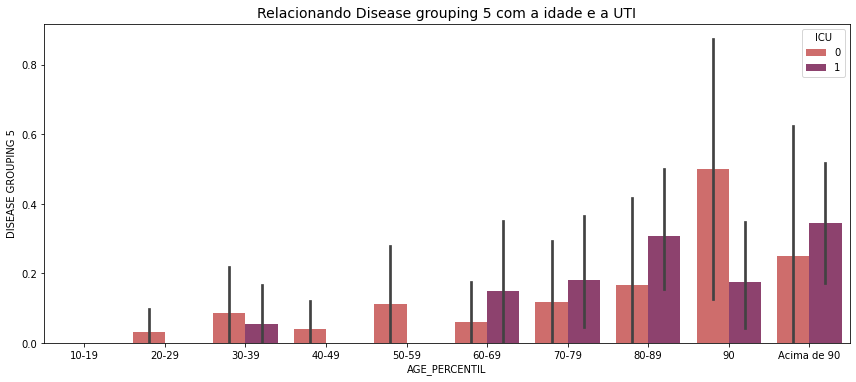

In [23]:
# Relacionando Disease Grouping 5 com idade
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Relacionando Disease grouping 5 com a idade e a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='DISEASE GROUPING 5', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.tight_layout()

**Contexto:**

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.

A DISEASE GROUPING 5 parece ter mais impacto nos portadores com idade mais avançada.

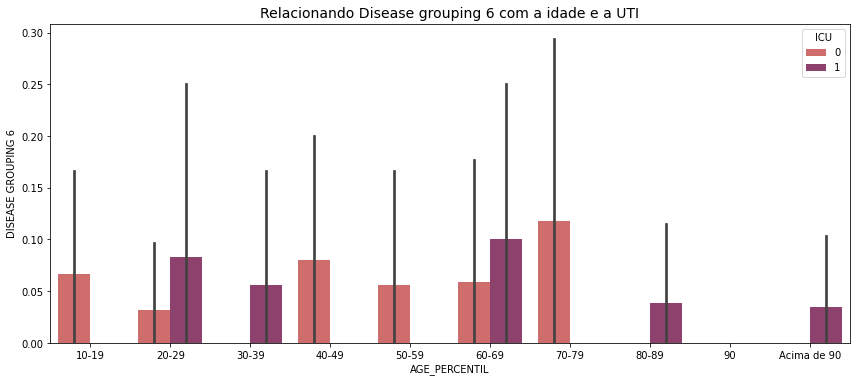

In [24]:
# Relacionando Disease Grouping 6 com idade
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Relacionando Disease grouping 6 com a idade e a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='DISEASE GROUPING 6', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.tight_layout()

**Contexto:**

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.

Conseguimos ver um impacto negativo da DISEASE GROUPING 6 em seus portadores, mas parece ser menor do que nas comorbidades que vimos anteriormente.

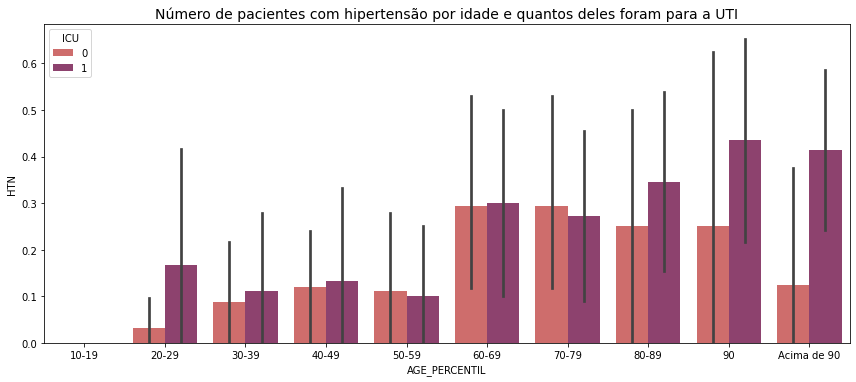

In [25]:
# Relacionando hipertensão com idade
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Número de pacientes com hipertensão por idade e quantos deles foram para a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='HTN', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.tight_layout()

**Contexto:**

- **ICU:**

-- 0 -> Representa os que não foram para a UTI;

-- 1 -> Representa os que foram para a UTI.

O impacto desta doença parece ser maior nas faixas etárias mais altas, com exceção da faixa dos 20 anos.

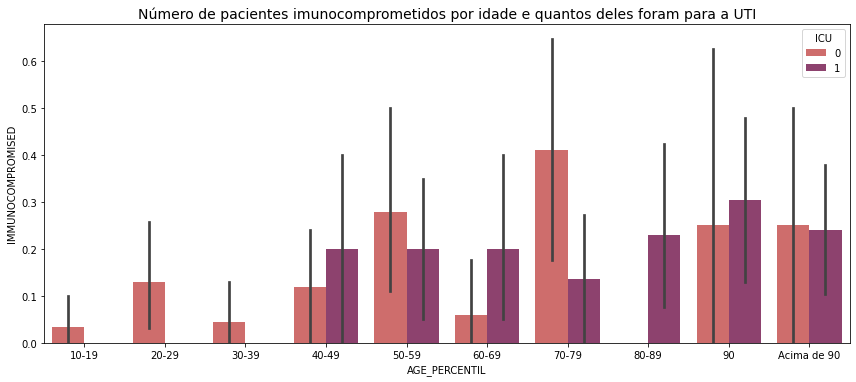

In [26]:
# Relacionando imunocomprometidos com idade e UTI
plt.figure(figsize=(12,10))
plt.subplot(2,1,2)
labels = {'10-19': '10th', '20-29': '20th', '30-39': '30th', '40-49': '40th', '50-59': '50th', '60-69': '60th', '70-79': '70th', '80-89': '80th', '90': '90th', 'Acima de 90': 'Above 90th'}
x = np.arange(len(labels))  # localização das labels
plt.title('Número de pacientes imunocomprometidos por idade e quantos deles foram para a UTI', fontsize=14)
ax = sns.barplot(x=uti_s_n['AGE_PERCENTIL'].sort_values(), y='IMMUNOCOMPROMISED', hue='ICU', data=uti_s_n, palette='flare')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.tight_layout()